- http://keunwoochoi.blogspot.com/2016/03/2.html
- http://www.rex-ai.info/docs/AI_Example_CNN_speech_recognize
- https://www.youtube.com/watch?v=oltGIc4uo5c
- https://youdaeng-com.tistory.com/5
- https://quokkas.tistory.com/37 : early stopping
- https://continuous-development.tistory.com/166 : stratified kfold
- https://deep-learning-study.tistory.com/476 fiter 시각화
- https://wyatt37.tistory.com/10 : random over sampling

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
from torchvision import transforms, datasets
import cv2
from torchvision import transforms, datasets
import pandas as pd
import os
from glob import glob
import torchvision.models as models
import sys

p = os.path.abspath('../..') # 상위 폴더를 사용하기 위해서.
sys.path.insert(1, p)
from pytorchtools.pytorchtools import EarlyStopping # 상위 폴더에 추가된 모듈.


if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
#DEVICE = torch.device('cpu')
print('Using Pytorch version : ',torch.__version__,' Device : ',DEVICE)

Using Pytorch version :  1.10.2  Device :  cuda


In [2]:
import wandb

#default param
run_config = dict(
    # spectrum
    sr=16000,
    n_fft=350,
    hop_length=50,
    win_length=350,
    # training
    batch_size=16,
)


# SVD 문장 데이터에서 Feature 추출
- mfcc

In [3]:
import numpy as np
import librosa, librosa.display 
import matplotlib.pyplot as plt
#window sizde : FFT를 할때 참조할 그래프 길이 ( 프레임 하나당 sample 수 )
#자연어 처리에서는 25ms 사용. https://ahnjg.tistory.com/93
#초당 50000hz 중 1250개씩 윈도우 사이즈로 사용.
#sr=16000
#win_length =  np.int64(sr/40) # 1250
#n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
#hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.

# 데이터 나누기 - Stratified KFold

- pathology : 1194 / healthy : 634 / 총 1828
- k = 5

## 1. test/ train 나누기


In [4]:
#1. train, test 나누기

import os
from glob import glob
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.model_selection import train_test_split # train , test 분리에 사용.


pathology = glob('D:/project/voice_pathology_ai/voice_data/organics/pathology/phrase/*.wav')
healthy = glob('D:/project/voice_pathology_ai/voice_data/organics/healthy/phrase/*.wav')
print("Pathology : ",len(pathology))
print("Healthy: ",len(healthy))

pathology= [ path.split("\\")[-1] for path in pathology] # path 데이터 변환.
healthy= [ path.split("\\")[-1] for path in healthy] # path 데이터 변환.
 # path 데이터 변환 #외부데이터로 가져오기위해서, 번호만 남긴다

    
X = pathology+healthy # path 데이터 합
print("총 데이터수 : ",len(X))
Y = [] # 라벨
for idx,x in enumerate(X):
    if idx<597:
        Y.append("pathology")
    else:
        Y.append("healthy")

X, X_test, Y, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, stratify=Y, random_state=456)
#stratify를 넣어서, test에도 라벨별 잘 분류되게 한다.

print("---")
print("훈련 셋 : ",len(Y),Counter(Y))
print("테스트 셋 : ",len(Y_test),Counter(Y_test))
print("---")

Pathology :  597
Healthy:  634
총 데이터수 :  1231
---
훈련 셋 :  984 Counter({'healthy': 507, 'pathology': 477})
테스트 셋 :  247 Counter({'healthy': 127, 'pathology': 120})
---


## 2. stratified k-fold

In [5]:
#1. train, test 나누기
#stratified kfold
import os
import random #데이터 shuffle 사용
from glob import glob
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from collections import Counter



skf_iris = StratifiedKFold(n_splits=5,shuffle=True,random_state=456)
cnt_iter = 0

X_train_list = [] #데이터 셋 보관
Y_train_list = []

X_valid_list = []
Y_valid_list = []

for train_idx, test_idx in skf_iris.split(X,Y):
    
    #split으로 반환된 인덱스를 이용하여, 학습 검증용 테스트 데이터 추출
    cnt_iter += 1
    X_train, X_valid = [X[idx] for idx in train_idx.tolist() ], [X[idx] for idx in test_idx.tolist() ]
    Y_train, Y_valid = [Y[idx] for idx in train_idx.tolist() ], [Y[idx] for idx in test_idx.tolist() ]
    
    X_train_list.append(X_train)
    X_valid_list.append(X_valid)
    
    Y_train_list.append(Y_train)
    Y_valid_list.append(Y_valid)
    
    
    #학습 및 예측
    
    label_train = Y_train
    label_test = Y_valid
    unique_train, train_counts = np.unique(label_train, return_counts = True)
    unique_test, test_counts = np.unique(label_test, return_counts = True)
    
    uniq_cnt_train = dict(zip(unique_train, train_counts))
    uniq_cnt_test = dict(zip(unique_test, test_counts))
    
    
    
    print('교차 검증 : {}'.format(cnt_iter))
    print('학습 레이블 데이터 분포 : \n', uniq_cnt_train)
    print('검증 레이블 데이터 분포 : \n', uniq_cnt_test,'\n')



교차 검증 : 1
학습 레이블 데이터 분포 : 
 {'healthy': 406, 'pathology': 381}
검증 레이블 데이터 분포 : 
 {'healthy': 101, 'pathology': 96} 

교차 검증 : 2
학습 레이블 데이터 분포 : 
 {'healthy': 406, 'pathology': 381}
검증 레이블 데이터 분포 : 
 {'healthy': 101, 'pathology': 96} 

교차 검증 : 3
학습 레이블 데이터 분포 : 
 {'healthy': 405, 'pathology': 382}
검증 레이블 데이터 분포 : 
 {'healthy': 102, 'pathology': 95} 

교차 검증 : 4
학습 레이블 데이터 분포 : 
 {'healthy': 405, 'pathology': 382}
검증 레이블 데이터 분포 : 
 {'healthy': 102, 'pathology': 95} 

교차 검증 : 5
학습 레이블 데이터 분포 : 
 {'healthy': 406, 'pathology': 382}
검증 레이블 데이터 분포 : 
 {'healthy': 101, 'pathology': 95} 



## 3. random over sampling

In [6]:
#2. random over sampling
for i in range(5):
    X_temp = np.array(X_train_list[i]).reshape(-1,1)#각 데이터를 다 행으로 넣음. (1194,1)
    #Y = np.array(Y)
    ros = RandomOverSampler(random_state = 123)
    X_res,Y_res = ros.fit_resample(X_temp,Y_train_list[i])
    
    print("\n fold{} ".format(i))
    print('before dataset shape {}'.format(Counter(Y_train_list[i])) )
    print('Resampled dataset shape {}'.format(Counter(Y_res)) )   
    
    #원래대로 돌리기
    X_res=X_res.reshape(1, -1)
    X_train_list[i]=X_res[0].tolist()
    Y_train_list[i]=Y_res





 fold0 
before dataset shape Counter({'healthy': 406, 'pathology': 381})
Resampled dataset shape Counter({'pathology': 406, 'healthy': 406})

 fold1 
before dataset shape Counter({'healthy': 406, 'pathology': 381})
Resampled dataset shape Counter({'healthy': 406, 'pathology': 406})

 fold2 
before dataset shape Counter({'healthy': 405, 'pathology': 382})
Resampled dataset shape Counter({'pathology': 405, 'healthy': 405})

 fold3 
before dataset shape Counter({'healthy': 405, 'pathology': 382})
Resampled dataset shape Counter({'pathology': 405, 'healthy': 405})

 fold4 
before dataset shape Counter({'healthy': 406, 'pathology': 382})
Resampled dataset shape Counter({'pathology': 406, 'healthy': 406})


In [7]:
import pickle

#16000 load
with open("D:/project/voice_pathology_ai/voice_data/organics/phrase_sig_dict.pickle","rb") as fr:
    phrase_dict_16000 = pickle.load(fr)

#32000 load
#with open("D:/project/voice_pathology_ai/voice_data/organics/phrase_sig_dict_32000.pickle","rb") as fr:
#    phrase_dict_32000 = pickle.load(fr)    

#50000 load
#with open("D:/project/voice_pathology_ai/voice_data/organics/phrase_sig_dict_50000.pickle","rb") as fr:
#    phrase_dict_50000 = pickle.load(fr)

    

# 데이터 정의
- 추가적으로 데이터의 크기를 맞춰주기 위해 3초로 padding 및 truncate 실시 https://sequencedata.tistory.com/25 FixAudioLength
- 논문에서는 400frame으로 설정.(여기서는 500frame)
- 전처리 방법 결정.


In [8]:
from torch.utils.data import Dataset, DataLoader

classes = ["healthy","pathology"]
#sr=50000
#win_length =  np.int64(16000/40) # 400
#n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding. 세로 길이
#hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.



class svd_dataset(Dataset):
    def __init__(self,data_path_list,classes,data_num,training,mel_params,transform=None,normalize=None):
        #클래스에서 사용할 인자를 받아 인스턴스 변수로 저장하는 일을 한다.
        #예를들면, 이미지의 경로 리스트를 저장하는 일을 하게 된다.
        
        #data_num : k 개 데이터 셋 중 어떤것을 쓸지
        #test인지 아닌지.
        
        self.path_list = data_path_list[data_num]
        self.data_num = data_num
        self.training = training
        self.label = svd_dataset.get_label(self.path_list,training,data_num)
        self.classes = classes
        self.transform = transform
        self.normalize = normalize
        
        # sweep params
        self.mel_params = mel_params
        # hop_length , win_length , n_mels , n_fft , f_max , batch_size
        
        
    
    @classmethod
    def get_label(cls,data_path_list,training,data_num):
        label_list=[]
        
        if training:
            for idx,x in enumerate(data_path_list):
                label_list.append(Y_train_list[data_num][idx])
        else:
            for idx,x in enumerate(data_path_list):
                label_list.append(Y_valid_list[data_num][idx])
        #print(label_list)
        return label_list
    
    
    def __len__(self):
        return len(self.path_list)
        #데이터 셋의 길이를 정수로 반환한다.     
    
       
    def __getitem__(self, idx):
        """
        1. path를 받아서, 소리에서 mfcc를 추출
        2. mfcc를 224프레임으로 패딩.
        3. resnet에 사용되기 위해 3채널로 복사(rgb 처럼)
        4. 0~1 정규화
        
        """
        sig = phrase_dict_16000[self.path_list[idx]]  
        
        length = self.mel_params['sr']*2 #300 padding을 위한 파라미터 (하이퍼 파라미터로인해 사이즈는 계속 바뀐다.)
        pad1d = lambda a, i: a[0:i] if a.shape[0] > i else np.hstack((a, np.zeros((i-a.shape[0]))))        
        sig = pad1d(sig,length)        
        
        ###signal norm
        sig = (sig-sig.mean())/sig.std()
        ###      
        
        stft = librosa.stft(sig, win_length=self.mel_params['win_length'],
                        n_fft=self.mel_params["n_fft"],
                        hop_length=self.mel_params["hop_length"]
                           )
        magnitude = np.abs(stft)
        log_spectrogram = librosa.amplitude_to_db(magnitude)        
                
        
        
        
        if self.transform:
            #print('transform')
            log_spectrogram=self.transform(log_spectrogram).type(torch.float32)# 데이터 0~1 정규화
            log_spectrogram=torch.stack([log_spectrogram,log_spectrogram,log_spectrogram])# 3채널로 복사.
            log_spectrogram = log_spectrogram.squeeze(dim=1)
            
            # global normalize
            if self.normalize:
                log_spectrogram=self.normalize(log_spectrogram)            
        else:
            #print("else")
            log_spectrogram = torch.from_numpy(log_spectrogram).type(torch.float32)
            log_spectrogram=log_spectrogram.unsqueeze(0)#cnn 사용위해서 추가
            #MFCCs = MFCCs.permute(2, 0, 1)
        return log_spectrogram, self.classes.index(self.label[idx])
    

In [9]:

# test set 제작을 위한 class
class svd_test_set(Dataset):
    def __init__(self,data_path_list,classes,mel_params,transform=None,normalize=None):
        #클래스에서 사용할 인자를 받아 인스턴스 변수로 저장하는 일을 한다.
        #예를들면, 이미지의 경로 리스트를 저장하는 일을 하게 된다.
        
        #data_num : k 개 데이터 셋 중 어떤것을 쓸지
        #test인지 아닌지.
        
        self.path_list = data_path_list
        self.label = svd_test_set.get_label(self.path_list)
        self.classes=classes
        self.transform=transform
        self.normalize=normalize
        
        # sweep params
        self.mel_params = mel_params
        # hop_length , win_length , n_mels , n_fft , f_max , batch_size        
        
    
    @classmethod
    def get_label(cls,data_path_list):
        label_list=[]
        
        for idx,x in enumerate(data_path_list):
            label_list.append(Y_test[idx])
        #print(label_list)
        return label_list
    
    def __len__(self):
        return len(self.path_list)
        #데이터 셋의 길이를 정수로 반환한다. 
        
    def __getitem__(self, idx):
        """
        1. path를 받아서, 소리에서 mfcc를 추출
        2. mfcc를 224프레임으로 패딩.
        3. resnet에 사용되기 위해 3채널로 복사(rgb 처럼)
        4. 0~1 정규화
        
        """
        sig = phrase_dict_16000[self.path_list[idx]]  
        
        length = self.mel_params['sr']*2 #300 padding을 위한 파라미터 (하이퍼 파라미터로인해 사이즈는 계속 바뀐다.)
        pad1d = lambda a, i: a[0:i] if a.shape[0] > i else np.hstack((a, np.zeros((i-a.shape[0]))))        
        sig = pad1d(sig,length)        
        
        ###signal norm
        sig = (sig-sig.mean())/sig.std()
        ###      
        
        stft = librosa.stft(sig, win_length=self.mel_params['win_length'],
                        n_fft=self.mel_params["n_fft"],
                        hop_length=self.mel_params["hop_length"]
                           )
        magnitude = np.abs(stft)
        log_spectrogram = librosa.amplitude_to_db(magnitude)        
                
        
        
        
        if self.transform:
            #print('transform')
            log_spectrogram=self.transform(log_spectrogram).type(torch.float32)# 데이터 0~1 정규화
            log_spectrogram=torch.stack([log_spectrogram,log_spectrogram,log_spectrogram])# 3채널로 복사.
            log_spectrogram = log_spectrogram.squeeze(dim=1)
            
            # global normalize
            if self.normalize:
                log_spectrogram=self.normalize(log_spectrogram)            
        else:
            #print("else")
            log_spectrogram = torch.from_numpy(log_spectrogram).type(torch.float32)
            log_spectrogram=log_spectrogram.unsqueeze(0)#cnn 사용위해서 추가
            #MFCCs = MFCCs.permute(2, 0, 1)
        return log_spectrogram, self.classes.index(self.label[idx])
    
    

# 데이터 로더

In [17]:
#3. 하이퍼 파라미터
BATCH_SIZE =  16 #한 배치당 32개 음성데이터
EPOCHS = 40 # 전체 데이터 셋을 50번 반복
lr=0.0001
augment_kind="no"


In [30]:
#DATA LOADER 함수가 BATCH_size 단위로 분리해 지정.

#확인을 위해 데이터셋 하나만 확인


train_loader = torch.utils.data.DataLoader(dataset = 
                                           svd_dataset(
                                               X_train_list,
                                               classes,
                                               transform = transforms.ToTensor(),#이걸 composed로 고쳐서 전처리 하도록 수정. to tensor는 -데이터는 노멀라이즈못함.
                                               #normalize=transforms.Normalize((-56.4917, -56.4917,-56.4917), (17.9446,17.9446,17.9446)),
                                               mel_params = dict(
                                                    sr = run_config['sr'],
                                                     n_fft = run_config["n_fft"],
                                                     win_length = run_config["win_length"],
                                                     hop_length = run_config["hop_length"],
                                               ),
                                               data_num=1,
                                               training=True
                                           ),
                                           batch_size = 16,
                                           shuffle = True,
                                           ) # 순서가 암기되는것을 막기위해.

validation_loader = torch.utils.data.DataLoader(dataset = 
                                           svd_dataset(
                                               X_valid_list,
                                               classes,
                                               transform = transforms.ToTensor(),
                                               mel_params = dict(
                                                   sr = run_config['sr'],
                                                     n_fft = run_config["n_fft"],
                                                     win_length = run_config["win_length"],
                                                     hop_length = run_config["hop_length"],
                                               ),                      
                                               #normalize=transforms.Normalize((-56.4917, -56.4917,-56.4917), (17.9446,17.9446,17.9446)),                                               
                                               data_num=1,
                                               training=False
                                           ),
                                           batch_size = 16,
                                           shuffle = True,) 



In [31]:
# 테스트 데이터 로더.

test_loader = torch.utils.data.DataLoader(dataset = 
                                               svd_test_set(
                                                   X_test,
                                                   classes,
                                                   mel_params = dict(
                                                       sr = run_config['sr'],
                                                         n_fft = run_config["n_fft"],
                                                         win_length = run_config["win_length"],
                                                         hop_length = run_config["hop_length"],
                                               ),                                            
                                                   #normalize=transforms.Normalize((-56.4917, -56.4917,-56.4917), (17.9446,17.9446,17.9446)),                                                   
                                                   transform = transforms.ToTensor(),
                                               ),
                                               batch_size = 16,
                                               shuffle = True,) 

# 데이터 확인

In [32]:

sr=16000
win_length =  run_config["win_length"] # 400
n_fft= run_config["n_fft"] # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding. 세로 길이
hop_length=run_config["hop_length"] #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.


X_train :  torch.Size([16, 3, 176, 641]) type: torch.FloatTensor
Y_train :  torch.Size([16]) type: torch.LongTensor
tensor(0)


Text(0.5, 1.0, 'log-STFT (dB)')

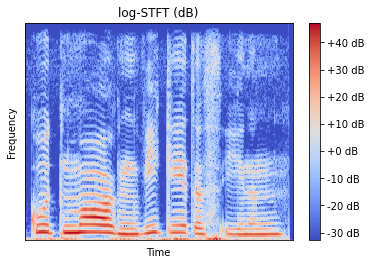

In [33]:
# 4. 데이터 확인하기
for (X_train,Y_train) in train_loader:
    print("X_train : ",X_train.size(),'type:',X_train.type())
    print("Y_train : ",Y_train.size(),'type:',Y_train.type())
    break
    
print(Y_train[0])
librosa.display.specshow(X_train[0][0].numpy(), sr=sr, hop_length=run_config["hop_length"])
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')
plt.title("log-STFT (dB)")
#batch: 32 / 3채널 / frame수: 500  /  feature수: 13

X_valid :  torch.Size([16, 3, 176, 641]) type: torch.FloatTensor
Y_valid :  torch.Size([16]) type: torch.LongTensor
tensor(0)


Text(0.5, 1.0, 'stft (dB)')

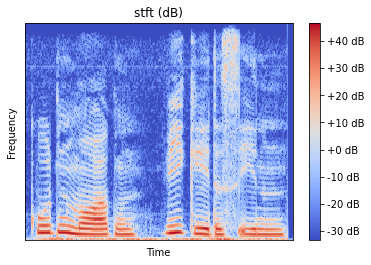

In [34]:
#valiation set 확인
for (X_valid,Y_valid) in validation_loader:
    print("X_valid : ",X_valid.size(),'type:',X_valid.type())
    print("Y_valid : ",Y_valid.size(),'type:',Y_valid.type())
    break

print(Y_valid[0])
librosa.display.specshow(X_valid[0][0].numpy(), sr=sr, hop_length=run_config["batch_size"])
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')
plt.title("stft (dB)")

#batch: 32 / 3채널 / frame수: 500  /  feature수: 13

X_valid :  torch.Size([16, 3, 176, 641]) type: torch.FloatTensor
Y_valid :  torch.Size([16]) type: torch.LongTensor
tensor(0)


Text(0.5, 1.0, 'stft (dB)')

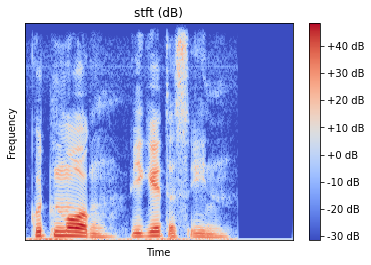

In [35]:
#valiation set 확인
for (test_data,test_label) in validation_loader:
    print("X_valid : ",test_data.size(),'type:',test_data.type())
    print("Y_valid : ",test_label.size(),'type:',test_label.type())
    break

print(Y_valid[0])
librosa.display.specshow(test_data[0][0].numpy(), sr=sr, hop_length=run_config["batch_size"])
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')
plt.title("stft (dB)")

#batch: 32 / 3채널 / frame수: 500  /  feature수: 13

# RESNET

In [36]:
# 모델 
# pretrained


def model_initialize():
    model = models.resnet18(pretrained=True).cuda()
    model.ftrs = model.fc.in_features # in_features : fully connected의 입력수.
    num_ftrs = model.fc.in_features
    
    model.fc = nn.Sequential(nn.Linear(num_ftrs, 64),
                             nn.BatchNorm1d(64),
                             nn.ReLU(),
                             nn.Dropout(p=0.5),
                             nn.Linear(64,50),
                             nn.BatchNorm1d(50),
                             nn.ReLU(),
                             nn.Dropout(p=0.5),
                             nn.Linear(50,2)
                            )

    model = model.cuda()
    return model
model=model_initialize()


In [37]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=lr)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [38]:
# get the model summary
from torchsummary import summary
#summary(model, input_size=(3, 128, 300), device=DEVICE.type)

In [39]:
#8. 학습
def train(model,train_loader,optimizer, log_interval):
    model.train()    
    correct = 0
    train_loss = 0
    for batch_idx,(image,label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        #데이터들 장비에 할당
        optimizer.zero_grad() # device 에 저장된 gradient 제거
        output = model(image) # model로 output을 계산
        loss = criterion(output, label) #loss 계산
        train_loss += loss.item()
        prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
        correct += prediction.eq(label.view_as(prediction)).sum().item()# 아웃풋이 배치 사이즈 32개라서.
        loss.backward() # loss 값을 이용해 gradient를 계산
        optimizer.step() # Gradient 값을 이용해 파라미터 업데이트.
    train_loss/=len(train_loader.dataset)
    train_accuracy = 100. * correct / len(train_loader.dataset)
    return train_loss,train_accuracy


In [40]:
#9. 학습 진행하며, validation 데이터로 모델 성능확인
def evaluate(model,valid_loader):
    model.eval()
    valid_loss = 0
    correct = 0
    #no_grad : 그래디언트 값 계산 막기.
    with torch.no_grad():
        for image, label in valid_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            valid_loss += criterion(output, label).item()
            prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
            correct += prediction.eq(label.view_as(prediction)).sum().item()# 아웃풋이 배치 사이즈 32개라서.
            #true.false값을 sum해줌. item
        valid_loss /= len(valid_loader.dataset)
        valid_accuracy = 100. * correct / len(valid_loader.dataset)
        return valid_loss,valid_accuracy


In [42]:
#데이터 로더 제작 함수

def load_data(data_ind):

    train_loader = torch.utils.data.DataLoader(dataset = 
                                               svd_dataset(
                                                   X_train_list,
                                                   classes,
                                                   transform = transforms.ToTensor(),#이걸 composed로 고쳐서 전처리 하도록 수정. to tensor는 -데이터는 노멀라이즈못함.
                                                   #normalize=transforms.Normalize((-56.4917, -56.4917,-56.4917), (17.9446,17.9446,17.9446)),
                                                   mel_params = dict(
                                                       sr = run_config['sr'],
                                                         n_fft = run_config["n_fft"],
                                                         win_length = run_config["win_length"],
                                                         hop_length = run_config["hop_length"],
                                                   ),
                                                   data_num=data_ind,
                                                   training=True
                                               ),
                                               batch_size = run_config["batch_size"],
                                               shuffle = True,
                                               ) # 순서가 암기되는것을 막기위해.

    validation_loader = torch.utils.data.DataLoader(dataset = 
                                               svd_dataset(
                                                   X_valid_list,
                                                   classes,
                                                   transform = transforms.ToTensor(),
                                                   mel_params = dict(
                                                       sr = run_config['sr'],
                                                       n_fft = run_config["n_fft"],
                                                       win_length = run_config["win_length"],
                                                       hop_length = run_config["hop_length"],
                                                   ),                      
                                                   #normalize=transforms.Normalize((-56.4917, -56.4917,-56.4917), (17.9446,17.9446,17.9446)),                                               
                                                   data_num=data_ind,
                                                   training=False
                                               ),
                                               batch_size = run_config["batch_size"],
                                               shuffle = True,) 

    return train_loader,validation_loader



In [44]:
#10. 학습 및 평가.
# resnet34 pretrained true
# kfold 적용

train_accs = []
valid_accs = []

for data_ind in range(1,6):

    check_path = '../../checkpoint/checkpoint_spectroHyp_ros_'+str(data_ind)+'_organics.pt'
    print(check_path)
    early_stopping = EarlyStopping(patience = 5, verbose = True, path=check_path)
    train_loader,validation_loader = load_data(data_ind-1)
    
    best_train_acc=0 # accuracy 기록용
    best_valid_acc=0
    
    model=model_initialize()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
    
    
    print("[{} 교차검증] 학습 시작\n ----- ".format(data_ind))
    for Epoch in range(1,EPOCHS+1):
        train_loss,train_accuracy=train(model,train_loader,optimizer,log_interval=31)
        valid_loss,valid_accuracy = evaluate(model, validation_loader)
        #wandb.log({
        #        "valid {}fold Accuracy".format(data_ind) : valid_accuracy,
        #        "valid {}fold loss".format(data_ind) : valid_loss},
        #        commit=True,
        #        step=Epoch)

        print("\n[EPOCH:{}]\t Train Loss:{:.4f}\t Train Acc:{:.2f} %  | \tValid Loss:{:.4f} \tValid Acc: {:.2f} %\n".
              format(Epoch,train_loss,train_accuracy,valid_loss,valid_accuracy))
        

        early_stopping(valid_loss, model)
        if -early_stopping.best_score == valid_loss:
            best_train_acc, best_valid_acc = train_accuracy,valid_accuracy
            #wandb.run.summary.update({"best_valid_{}fold_acc".format(data_ind) : best_valid_acc})
        
        if early_stopping.early_stop:
                train_accs.append(best_train_acc)
                valid_accs.append(best_valid_acc)
                print("[{} 교차검증] Early stopping".format(data_ind))
                break

        if Epoch==EPOCHS:
            #만약 early stop 없이 40 epoch라서 중지 된 경우.
            train_accs.append(best_train_acc)
            valid_accs.append(best_valid_acc)

../../checkpoint/checkpoint_spectroHyp_ros_1_organics.pt
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0356	 Train Acc:69.95 %  | 	Valid Loss:0.0323 	Valid Acc: 79.19 %

Validation loss decreased (inf --> 0.032347).  Saving model ...

[EPOCH:2]	 Train Loss:0.0297	 Train Acc:80.79 %  | 	Valid Loss:0.0287 	Valid Acc: 84.77 %

Validation loss decreased (0.032347 --> 0.028658).  Saving model ...

[EPOCH:3]	 Train Loss:0.0243	 Train Acc:87.32 %  | 	Valid Loss:0.0275 	Valid Acc: 84.77 %

Validation loss decreased (0.028658 --> 0.027522).  Saving model ...

[EPOCH:4]	 Train Loss:0.0206	 Train Acc:91.75 %  | 	Valid Loss:0.0277 	Valid Acc: 87.31 %

EarlyStopping counter: 1 out of 5

[EPOCH:5]	 Train Loss:0.0170	 Train Acc:94.46 %  | 	Valid Loss:0.0286 	Valid Acc: 84.77 %

EarlyStopping counter: 2 out of 5

[EPOCH:6]	 Train Loss:0.0143	 Train Acc:97.29 %  | 	Valid Loss:0.0266 	Valid Acc: 83.76 %

Validation loss decreased (0.027522 --> 0.026649).  Saving model ...

[EPOCH:7]	 Train Loss:0.0125


[EPOCH:18]	 Train Loss:0.0048	 Train Acc:99.38 %  | 	Valid Loss:0.0253 	Valid Acc: 84.26 %

EarlyStopping counter: 2 out of 5

[EPOCH:19]	 Train Loss:0.0041	 Train Acc:99.51 %  | 	Valid Loss:0.0248 	Valid Acc: 85.28 %

EarlyStopping counter: 3 out of 5

[EPOCH:20]	 Train Loss:0.0044	 Train Acc:99.51 %  | 	Valid Loss:0.0225 	Valid Acc: 88.32 %

EarlyStopping counter: 4 out of 5

[EPOCH:21]	 Train Loss:0.0059	 Train Acc:97.90 %  | 	Valid Loss:0.0316 	Valid Acc: 78.17 %

EarlyStopping counter: 5 out of 5
[3 교차검증] Early stopping
../../checkpoint/checkpoint_spectroHyp_ros_4_organics.pt
[4 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0391	 Train Acc:65.43 %  | 	Valid Loss:0.0324 	Valid Acc: 79.19 %

Validation loss decreased (inf --> 0.032384).  Saving model ...

[EPOCH:2]	 Train Loss:0.0303	 Train Acc:79.75 %  | 	Valid Loss:0.0293 	Valid Acc: 82.74 %

Validation loss decreased (0.032384 --> 0.029293).  Saving model ...

[EPOCH:3]	 Train Loss:0.0248	 Train Acc:85.80 %  | 	Valid Loss:0.0284 

# Model 결과 확인

In [45]:
sum_valid=0
for data_ind in range(5):
    print("[{} 교차검증] train ACC : {:.4f} |\t valid ACC: {:.4f} ".format(data_ind+1,train_accs[data_ind],valid_accs[data_ind] ))
    sum_valid+=valid_accs[data_ind]
    
print("평균 검증 정확도",sum_valid/5,"%")

[1 교차검증] train ACC : 99.3842 |	 valid ACC: 87.8173 
[2 교차검증] train ACC : 99.7537 |	 valid ACC: 88.8325 
[3 교차검증] train ACC : 98.0247 |	 valid ACC: 86.2944 
[4 교차검증] train ACC : 100.0000 |	 valid ACC: 86.8020 
[5 교차검증] train ACC : 98.8916 |	 valid ACC: 89.7959 
평균 검증 정확도 87.90842225214959 %


# Model Test

- test set
- confusion matrix

In [46]:
#confusion matrix 계산
#test set 계산.
def test_evaluate(model,test_loader):
    model.eval()
    test_loss = 0
    predictions = []
    answers = []
    #no_grad : 그래디언트 값 계산 막기.
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
            answers +=label
            predictions +=prediction
            
        return predictions,answers,test_loss
            

In [48]:
# Confusion matrix (resnet18)
# kfold의 confusion matrix는 계산 방법이 다르다.
# 모델을 각각 불러와서 test set을 평가한다.

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

cf = np.zeros((2,2))
cf_list = []
average_accuracy = 0
average_fscore = 0
average_uar = 0

for data_ind in range(1,6):

    check_path = '../../checkpoint/checkpoint_spectroHyp_ros_'+str(data_ind)+'_organics.pt'
    model.load_state_dict(torch.load(check_path))

    predictions,answers,test_loss = test_evaluate(model, test_loader)
    predictions=[ dat.cpu().numpy() for dat in predictions]
    answers=[ dat.cpu().numpy() for dat in answers]

    
    cf = confusion_matrix(answers, predictions)
    cf_list.append(cf)
    
    acc = (cf[0,0]+cf[1,1])/(cf[0,0]+cf[0,1]+cf[1,0]+cf[1,1])
    average_accuracy+=acc
    
    precision=cf[0,0]/(cf[0,0]+cf[1,0])
    recall=cf[0,0]/(cf[0,0]+cf[1,0])
    
    specificity=cf[1,1]/(cf[0,1]+cf[1,1])
    average_uar += (specificity+recall)/2
    #fscore=2*precision*recall/(precision+recall)
    
    #fscroe macro추가
    fscore = f1_score(answers,predictions,average='macro')
    average_fscore+=fscore
    
    print('{}번 모델'.format(data_ind))
    print("Accuracy : {:.4f}% ".format(acc*100))
    #print("Precision (pathology 예측한 것중 맞는 것) : {:.4f}".format(precision))
    print("recall (실제 pathology 중  예측이 맞는 것) : {:.4f}".format(recall))
    print("specificity : {:.4f}%".format(specificity))
    print("UAR : {:.4f}%".format( (specificity+recall)/2 ))
    
    
    print("f score : {:.4f} ".format(fscore))
    print(cf)
    print("-----")
    #### wandb
    
    #wandb.run.summary.update({"test_{}fold_acc".format(data_ind) : acc*100})
    #wandb.run.summary.update({"test_{}fold_f1".format(data_ind) : fscore})
    #wandb.run.summary.update({"test_{}fold_UAR".format(data_ind) : (specificity+recall)/2})
    #wandb.log({"{}fold Confusion Matrix".format(data_ind) :wandb.sklearn.plot_confusion_matrix(answers, predictions, labels=classes)})
    
    ####
    
    
    

print("평균 acc : {:.4f}".format(average_accuracy/5))
print("평균 UAR : {:.4f}".format(average_uar/5))
print("평균 f1score : {:.4f}".format(average_fscore/5))
#wandb.run.summary.update({"test 평균 acc" : average_accuracy/5})
#wandb.run.summary.update({"test 평균 f1" : average_fscore/5})
#wandb.run.summary.update({"test 평균 UAR" : average_uar/5})



1번 모델
Accuracy : 88.2591% 
recall (실제 pathology 중  예측이 맞는 것) : 0.8828
specificity : 0.8824%
UAR : 0.8826%
f score : 0.8825 
[[113  14]
 [ 15 105]]
-----
2번 모델
Accuracy : 86.2348% 
recall (실제 pathology 중  예측이 맞는 것) : 0.8661
specificity : 0.8583%
UAR : 0.8622%
f score : 0.8622 
[[110  17]
 [ 17 103]]
-----
3번 모델
Accuracy : 86.2348% 
recall (실제 pathology 중  예측이 맞는 것) : 0.8345
specificity : 0.8981%
UAR : 0.8663%
f score : 0.8615 
[[116  11]
 [ 23  97]]
-----
4번 모델
Accuracy : 88.2591% 
recall (실제 pathology 중  예측이 맞는 것) : 0.8769
specificity : 0.8889%
UAR : 0.8829%
f score : 0.8824 
[[114  13]
 [ 16 104]]
-----
5번 모델
Accuracy : 87.0445% 
recall (실제 pathology 중  예측이 맞는 것) : 0.8467
specificity : 0.9000%
UAR : 0.8734%
f score : 0.8698 
[[116  11]
 [ 21  99]]
-----
평균 acc : 0.8721
평균 UAR : 0.8735
평균 f1score : 0.8717
